In [ ]:
import sys
import os

# Add the root folder of your project
root_path = os.path.abspath(os.path.join("..", ".."))  # two levels up from experiments
sys.path.append(root_path)
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re


from weather_classification.weather_dataset import WeatherDataset
from weather_classification.train import train_model
from weather_classification.modeling.binary_classifier import BinaryWeatherClassifier_HighRes, BinaryWeatherClassifier_LowRes
from weather_classification.seed_utils import set_seed
set_seed(1234)


In [ ]:
# For high-resolution pairs (e.g., frost vs glaze)
highres_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ## Meter normalization?
])

# For low-resolution pairs (e.g., rain vs lightning, etc.)
lowres_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [12]:
def create_binary_dataset(dataset, class_pair):
    idx1 = dataset.class_to_idx[class_pair[0]]
    idx2 = dataset.class_to_idx[class_pair[1]]

    indices = [i for i, (_, lbl) in enumerate(dataset.samples) if lbl in (idx1, idx2)]
    idx_map = {idx1: 0, idx2: 1}

    def remap_collate(batch):
        imgs, labels = zip(*batch)
        imgs = torch.stack(imgs)
        labels = torch.tensor([idx_map[l.item() if torch.is_tensor(l) else l] for l in labels])
        return imgs, labels

    subset = Subset(dataset, indices)
    return subset, remap_collate


In [ ]:
def train_binary_pair(model_class, class_pair, train_dir, val_dir, save_dir,
                      device="cuda", epochs=20, lr=1e-3):
    os.makedirs(save_dir, exist_ok=True)

    # Pick transform depending on model
    if model_class.__name__.endswith("HighRes"):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            # normalize
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    # Load datasets
    train_dataset = WeatherDataset(train_dir, transform=transform)
    val_dataset = WeatherDataset(val_dir, transform=transform)

    # Filter to pair
    train_subset, train_collate = create_binary_dataset(train_dataset, class_pair)
    val_subset, val_collate = create_binary_dataset(val_dataset, class_pair)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=train_collate)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=val_collate)

    # Initialize model
    model = model_class(class_pair=class_pair).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for imgs, labels in tqdm(train_loader, desc=f"[{class_pair}] Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += (preds == labels).sum().item()

        train_loss = running_loss / len(train_subset)
        train_acc = running_corrects / len(train_subset)

        # Validation
        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[{class_pair}] Epoch {epoch+1}/{epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                preds = outputs.argmax(1)
                val_loss += loss.item() * imgs.size(0)
                val_corrects += (preds == labels).sum().item()

        val_loss /= len(val_subset)
        val_acc = val_corrects / len(val_subset)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(save_dir, f"{class_pair[0]}_{class_pair[1]}_{model_class.__name__}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"✅ Saved best model to {model_path} (val_acc={val_acc:.3f})")

    return model


In [14]:
confused_pairs = [
    ("frost", "glaze"),
    ("rain", "lightning"),
    ("snow", "rime"),
    ("glaze", "hail"),
]

train_dir = "../../data/train"
val_dir = "../../data/val"
save_dir = "../../models/binary_models"
device = "cuda" if torch.cuda.is_available() else "cpu"

for pair in confused_pairs:
    print(f"\n============================")
    print(f" Training pair: {pair}")
    print(f"============================")

    # HighRes
    train_binary_pair(BinaryWeatherClassifier_HighRes, pair,
                      train_dir=train_dir,
                      val_dir=val_dir,
                      save_dir=save_dir,
                      device=device, epochs=20)

    # LowRes
    train_binary_pair(BinaryWeatherClassifier_LowRes, pair,
                      train_dir=train_dir,
                      val_dir=val_dir,
                      save_dir=save_dir,
                      device=device, epochs=20)



 Training pair: ('frost', 'glaze')


[('frost', 'glaze')] Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Epoch 1/20 | Train Acc: 0.567 | Val Acc: 0.582
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_HighRes.pth (val_acc=0.582)


[('frost', 'glaze')] Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


Epoch 2/20 | Train Acc: 0.598 | Val Acc: 0.645
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_HighRes.pth (val_acc=0.645)


[('frost', 'glaze')] Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Epoch 3/20 | Train Acc: 0.681 | Val Acc: 0.709
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_HighRes.pth (val_acc=0.709)


[('frost', 'glaze')] Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Epoch 4/20 | Train Acc: 0.688 | Val Acc: 0.736
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_HighRes.pth (val_acc=0.736)


[('frost', 'glaze')] Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Epoch 5/20 | Train Acc: 0.705 | Val Acc: 0.673


[('frost', 'glaze')] Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Epoch 6/20 | Train Acc: 0.684 | Val Acc: 0.727


[('frost', 'glaze')] Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Epoch 7/20 | Train Acc: 0.719 | Val Acc: 0.582


[('frost', 'glaze')] Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Epoch 8/20 | Train Acc: 0.736 | Val Acc: 0.718


[('frost', 'glaze')] Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


Epoch 9/20 | Train Acc: 0.663 | Val Acc: 0.627


[('frost', 'glaze')] Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


Epoch 10/20 | Train Acc: 0.687 | Val Acc: 0.673


[('frost', 'glaze')] Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Epoch 11/20 | Train Acc: 0.721 | Val Acc: 0.718


[('frost', 'glaze')] Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Epoch 12/20 | Train Acc: 0.707 | Val Acc: 0.800
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_HighRes.pth (val_acc=0.800)


[('frost', 'glaze')] Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]


Epoch 13/20 | Train Acc: 0.754 | Val Acc: 0.636


[('frost', 'glaze')] Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch 14/20 | Train Acc: 0.724 | Val Acc: 0.627


[('frost', 'glaze')] Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]


Epoch 15/20 | Train Acc: 0.758 | Val Acc: 0.809
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_HighRes.pth (val_acc=0.809)


[('frost', 'glaze')] Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


Epoch 16/20 | Train Acc: 0.763 | Val Acc: 0.627


[('frost', 'glaze')] Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Epoch 17/20 | Train Acc: 0.799 | Val Acc: 0.627


[('frost', 'glaze')] Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch 18/20 | Train Acc: 0.797 | Val Acc: 0.736


[('frost', 'glaze')] Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch 19/20 | Train Acc: 0.806 | Val Acc: 0.791


[('frost', 'glaze')] Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Epoch 20/20 | Train Acc: 0.822 | Val Acc: 0.809


[('frost', 'glaze')] Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


Epoch 1/20 | Train Acc: 0.606 | Val Acc: 0.545
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_LowRes.pth (val_acc=0.545)


[('frost', 'glaze')] Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.21it/s]


Epoch 2/20 | Train Acc: 0.682 | Val Acc: 0.745
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_LowRes.pth (val_acc=0.745)


[('frost', 'glaze')] Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.15it/s]


Epoch 3/20 | Train Acc: 0.709 | Val Acc: 0.645


[('frost', 'glaze')] Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.26it/s]


Epoch 4/20 | Train Acc: 0.746 | Val Acc: 0.718


[('frost', 'glaze')] Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.46it/s]


Epoch 5/20 | Train Acc: 0.758 | Val Acc: 0.709


[('frost', 'glaze')] Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.17it/s]


Epoch 6/20 | Train Acc: 0.738 | Val Acc: 0.682


[('frost', 'glaze')] Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


Epoch 7/20 | Train Acc: 0.770 | Val Acc: 0.782
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_LowRes.pth (val_acc=0.782)


[('frost', 'glaze')] Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  8.93it/s]


Epoch 8/20 | Train Acc: 0.776 | Val Acc: 0.745


[('frost', 'glaze')] Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]


Epoch 9/20 | Train Acc: 0.840 | Val Acc: 0.736


[('frost', 'glaze')] Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.41it/s]


Epoch 10/20 | Train Acc: 0.834 | Val Acc: 0.764


[('frost', 'glaze')] Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.01it/s]


Epoch 11/20 | Train Acc: 0.864 | Val Acc: 0.664


[('frost', 'glaze')] Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.60it/s]


Epoch 12/20 | Train Acc: 0.870 | Val Acc: 0.627


[('frost', 'glaze')] Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


Epoch 13/20 | Train Acc: 0.893 | Val Acc: 0.727


[('frost', 'glaze')] Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.45it/s]


Epoch 14/20 | Train Acc: 0.901 | Val Acc: 0.782


[('frost', 'glaze')] Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


Epoch 15/20 | Train Acc: 0.926 | Val Acc: 0.736


[('frost', 'glaze')] Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch 16/20 | Train Acc: 0.920 | Val Acc: 0.727


[('frost', 'glaze')] Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  8.51it/s]


Epoch 17/20 | Train Acc: 0.943 | Val Acc: 0.800
✅ Saved best model to ../../models/binary_models\frost_glaze_BinaryWeatherClassifier_LowRes.pth (val_acc=0.800)


[('frost', 'glaze')] Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.66it/s]


Epoch 18/20 | Train Acc: 0.960 | Val Acc: 0.718


[('frost', 'glaze')] Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.66it/s]


Epoch 19/20 | Train Acc: 0.957 | Val Acc: 0.800


[('frost', 'glaze')] Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


Epoch 20/20 | Train Acc: 0.965 | Val Acc: 0.745

 Training pair: ('rain', 'lightning')


[('rain', 'lightning')] Epoch 1/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Epoch 1/20 | Train Acc: 0.768 | Val Acc: 0.416
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_HighRes.pth (val_acc=0.416)


[('rain', 'lightning')] Epoch 2/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


Epoch 2/20 | Train Acc: 0.904 | Val Acc: 0.854
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_HighRes.pth (val_acc=0.854)


[('rain', 'lightning')] Epoch 3/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]


Epoch 3/20 | Train Acc: 0.943 | Val Acc: 0.955
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_HighRes.pth (val_acc=0.955)


[('rain', 'lightning')] Epoch 4/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


Epoch 4/20 | Train Acc: 0.943 | Val Acc: 0.899


[('rain', 'lightning')] Epoch 5/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Epoch 5/20 | Train Acc: 0.940 | Val Acc: 0.978
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_HighRes.pth (val_acc=0.978)


[('rain', 'lightning')] Epoch 6/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Epoch 6/20 | Train Acc: 0.971 | Val Acc: 0.989
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_HighRes.pth (val_acc=0.989)


[('rain', 'lightning')] Epoch 7/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


Epoch 7/20 | Train Acc: 0.968 | Val Acc: 0.989


[('rain', 'lightning')] Epoch 8/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


Epoch 8/20 | Train Acc: 0.947 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 9/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


Epoch 9/20 | Train Acc: 0.946 | Val Acc: 0.978


[('rain', 'lightning')] Epoch 10/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


Epoch 10/20 | Train Acc: 0.940 | Val Acc: 0.989


[('rain', 'lightning')] Epoch 11/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Epoch 11/20 | Train Acc: 0.968 | Val Acc: 0.978


[('rain', 'lightning')] Epoch 12/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


Epoch 12/20 | Train Acc: 0.958 | Val Acc: 0.989


[('rain', 'lightning')] Epoch 13/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


Epoch 13/20 | Train Acc: 0.958 | Val Acc: 0.989


[('rain', 'lightning')] Epoch 14/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Epoch 14/20 | Train Acc: 0.976 | Val Acc: 0.978


[('rain', 'lightning')] Epoch 15/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Epoch 15/20 | Train Acc: 0.965 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 16/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


Epoch 16/20 | Train Acc: 0.981 | Val Acc: 0.978


[('rain', 'lightning')] Epoch 17/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


Epoch 17/20 | Train Acc: 0.981 | Val Acc: 0.989


[('rain', 'lightning')] Epoch 18/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


Epoch 18/20 | Train Acc: 0.979 | Val Acc: 0.933


[('rain', 'lightning')] Epoch 19/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


Epoch 19/20 | Train Acc: 0.961 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 20/20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]


Epoch 20/20 | Train Acc: 0.981 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 1/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 10.91it/s]


Epoch 1/20 | Train Acc: 0.899 | Val Acc: 0.416
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_LowRes.pth (val_acc=0.416)


[('rain', 'lightning')] Epoch 2/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.30it/s]


Epoch 2/20 | Train Acc: 0.939 | Val Acc: 0.910
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_LowRes.pth (val_acc=0.910)


[('rain', 'lightning')] Epoch 3/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.71it/s]


Epoch 3/20 | Train Acc: 0.967 | Val Acc: 0.966
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_LowRes.pth (val_acc=0.966)


[('rain', 'lightning')] Epoch 4/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.99it/s]


Epoch 4/20 | Train Acc: 0.969 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 5/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.77it/s]


Epoch 5/20 | Train Acc: 0.974 | Val Acc: 0.955


[('rain', 'lightning')] Epoch 6/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.40it/s]


Epoch 6/20 | Train Acc: 0.976 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 7/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.20it/s]


Epoch 7/20 | Train Acc: 0.972 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 8/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.71it/s]


Epoch 8/20 | Train Acc: 0.983 | Val Acc: 0.955


[('rain', 'lightning')] Epoch 9/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.66it/s]


Epoch 9/20 | Train Acc: 0.979 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 10/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


Epoch 10/20 | Train Acc: 0.989 | Val Acc: 0.944


[('rain', 'lightning')] Epoch 11/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.77it/s]


Epoch 11/20 | Train Acc: 0.971 | Val Acc: 0.944


[('rain', 'lightning')] Epoch 12/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 13.04it/s]


Epoch 12/20 | Train Acc: 0.981 | Val Acc: 0.955


[('rain', 'lightning')] Epoch 13/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 10.68it/s]


Epoch 13/20 | Train Acc: 0.993 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 14/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.55it/s]


Epoch 14/20 | Train Acc: 0.990 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 15/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.55it/s]


Epoch 15/20 | Train Acc: 0.978 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 16/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


Epoch 16/20 | Train Acc: 0.989 | Val Acc: 0.978
✅ Saved best model to ../../models/binary_models\rain_lightning_BinaryWeatherClassifier_LowRes.pth (val_acc=0.978)


[('rain', 'lightning')] Epoch 17/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.76it/s]


Epoch 17/20 | Train Acc: 0.997 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 18/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 13.16it/s]


Epoch 18/20 | Train Acc: 0.994 | Val Acc: 0.978


[('rain', 'lightning')] Epoch 19/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 12.55it/s]


Epoch 19/20 | Train Acc: 0.999 | Val Acc: 0.966


[('rain', 'lightning')] Epoch 20/20 [Val]: 100%|██████████| 3/3 [00:00<00:00, 13.04it/s]


Epoch 20/20 | Train Acc: 0.982 | Val Acc: 0.966

 Training pair: ('snow', 'rime')


[('snow', 'rime')] Epoch 1/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


Epoch 1/20 | Train Acc: 0.643 | Val Acc: 0.775
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_HighRes.pth (val_acc=0.775)


[('snow', 'rime')] Epoch 2/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]


Epoch 2/20 | Train Acc: 0.735 | Val Acc: 0.792
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_HighRes.pth (val_acc=0.792)


[('snow', 'rime')] Epoch 3/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


Epoch 3/20 | Train Acc: 0.794 | Val Acc: 0.747


[('snow', 'rime')] Epoch 4/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]


Epoch 4/20 | Train Acc: 0.815 | Val Acc: 0.815
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_HighRes.pth (val_acc=0.815)


[('snow', 'rime')] Epoch 5/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


Epoch 5/20 | Train Acc: 0.812 | Val Acc: 0.787


[('snow', 'rime')] Epoch 6/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


Epoch 6/20 | Train Acc: 0.815 | Val Acc: 0.730


[('snow', 'rime')] Epoch 7/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]


Epoch 7/20 | Train Acc: 0.839 | Val Acc: 0.815


[('snow', 'rime')] Epoch 8/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


Epoch 8/20 | Train Acc: 0.841 | Val Acc: 0.770


[('snow', 'rime')] Epoch 9/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


Epoch 9/20 | Train Acc: 0.852 | Val Acc: 0.820
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_HighRes.pth (val_acc=0.820)


[('snow', 'rime')] Epoch 10/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


Epoch 10/20 | Train Acc: 0.862 | Val Acc: 0.803


[('snow', 'rime')] Epoch 11/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


Epoch 11/20 | Train Acc: 0.862 | Val Acc: 0.747


[('snow', 'rime')] Epoch 12/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


Epoch 12/20 | Train Acc: 0.879 | Val Acc: 0.843
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_HighRes.pth (val_acc=0.843)


[('snow', 'rime')] Epoch 13/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


Epoch 13/20 | Train Acc: 0.873 | Val Acc: 0.826


[('snow', 'rime')] Epoch 14/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


Epoch 14/20 | Train Acc: 0.879 | Val Acc: 0.865
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_HighRes.pth (val_acc=0.865)


[('snow', 'rime')] Epoch 15/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


Epoch 15/20 | Train Acc: 0.879 | Val Acc: 0.719


[('snow', 'rime')] Epoch 16/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]


Epoch 16/20 | Train Acc: 0.895 | Val Acc: 0.815


[('snow', 'rime')] Epoch 17/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


Epoch 17/20 | Train Acc: 0.888 | Val Acc: 0.809


[('snow', 'rime')] Epoch 18/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


Epoch 18/20 | Train Acc: 0.886 | Val Acc: 0.820


[('snow', 'rime')] Epoch 19/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.07it/s]


Epoch 19/20 | Train Acc: 0.892 | Val Acc: 0.764


[('snow', 'rime')] Epoch 20/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


Epoch 20/20 | Train Acc: 0.898 | Val Acc: 0.848


[('snow', 'rime')] Epoch 1/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 1/20 | Train Acc: 0.769 | Val Acc: 0.770
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_LowRes.pth (val_acc=0.770)


[('snow', 'rime')] Epoch 2/20 [Val]: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


Epoch 2/20 | Train Acc: 0.828 | Val Acc: 0.803
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_LowRes.pth (val_acc=0.803)


[('snow', 'rime')] Epoch 3/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.33it/s]


Epoch 3/20 | Train Acc: 0.839 | Val Acc: 0.820
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_LowRes.pth (val_acc=0.820)


[('snow', 'rime')] Epoch 4/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


Epoch 4/20 | Train Acc: 0.855 | Val Acc: 0.826
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_LowRes.pth (val_acc=0.826)


[('snow', 'rime')] Epoch 5/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.24it/s]


Epoch 5/20 | Train Acc: 0.862 | Val Acc: 0.820


[('snow', 'rime')] Epoch 6/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]


Epoch 6/20 | Train Acc: 0.890 | Val Acc: 0.831
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_LowRes.pth (val_acc=0.831)


[('snow', 'rime')] Epoch 7/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.50it/s]


Epoch 7/20 | Train Acc: 0.883 | Val Acc: 0.809


[('snow', 'rime')] Epoch 8/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


Epoch 8/20 | Train Acc: 0.899 | Val Acc: 0.809


[('snow', 'rime')] Epoch 9/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


Epoch 9/20 | Train Acc: 0.897 | Val Acc: 0.854
✅ Saved best model to ../../models/binary_models\snow_rime_BinaryWeatherClassifier_LowRes.pth (val_acc=0.854)


[('snow', 'rime')] Epoch 10/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]


Epoch 10/20 | Train Acc: 0.912 | Val Acc: 0.820


[('snow', 'rime')] Epoch 11/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]


Epoch 11/20 | Train Acc: 0.912 | Val Acc: 0.854


[('snow', 'rime')] Epoch 12/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.51it/s]


Epoch 12/20 | Train Acc: 0.912 | Val Acc: 0.831


[('snow', 'rime')] Epoch 13/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.30it/s]


Epoch 13/20 | Train Acc: 0.922 | Val Acc: 0.809


[('snow', 'rime')] Epoch 14/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Epoch 14/20 | Train Acc: 0.933 | Val Acc: 0.854


[('snow', 'rime')] Epoch 15/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.50it/s]


Epoch 15/20 | Train Acc: 0.930 | Val Acc: 0.815


[('snow', 'rime')] Epoch 16/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Epoch 16/20 | Train Acc: 0.938 | Val Acc: 0.809


[('snow', 'rime')] Epoch 17/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.42it/s]


Epoch 17/20 | Train Acc: 0.953 | Val Acc: 0.854


[('snow', 'rime')] Epoch 18/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.56it/s]


Epoch 18/20 | Train Acc: 0.951 | Val Acc: 0.820


[('snow', 'rime')] Epoch 19/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.47it/s]


Epoch 19/20 | Train Acc: 0.963 | Val Acc: 0.775


[('snow', 'rime')] Epoch 20/20 [Val]: 100%|██████████| 6/6 [00:00<00:00,  7.72it/s]


Epoch 20/20 | Train Acc: 0.948 | Val Acc: 0.848

 Training pair: ('glaze', 'hail')


[('glaze', 'hail')] Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch 1/20 | Train Acc: 0.511 | Val Acc: 0.525
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.525)


[('glaze', 'hail')] Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 2/20 | Train Acc: 0.529 | Val Acc: 0.574
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.574)


[('glaze', 'hail')] Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 3/20 | Train Acc: 0.590 | Val Acc: 0.607
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.607)


[('glaze', 'hail')] Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Epoch 4/20 | Train Acc: 0.746 | Val Acc: 0.787
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.787)


[('glaze', 'hail')] Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch 5/20 | Train Acc: 0.787 | Val Acc: 0.672


[('glaze', 'hail')] Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 6/20 | Train Acc: 0.773 | Val Acc: 0.811
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.811)


[('glaze', 'hail')] Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Epoch 7/20 | Train Acc: 0.801 | Val Acc: 0.779


[('glaze', 'hail')] Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch 8/20 | Train Acc: 0.824 | Val Acc: 0.730


[('glaze', 'hail')] Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Epoch 9/20 | Train Acc: 0.847 | Val Acc: 0.836
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.836)


[('glaze', 'hail')] Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch 10/20 | Train Acc: 0.868 | Val Acc: 0.844
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.844)


[('glaze', 'hail')] Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch 11/20 | Train Acc: 0.846 | Val Acc: 0.713


[('glaze', 'hail')] Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Epoch 12/20 | Train Acc: 0.883 | Val Acc: 0.836


[('glaze', 'hail')] Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 13/20 | Train Acc: 0.869 | Val Acc: 0.795


[('glaze', 'hail')] Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch 14/20 | Train Acc: 0.881 | Val Acc: 0.877
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.877)


[('glaze', 'hail')] Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch 15/20 | Train Acc: 0.880 | Val Acc: 0.852


[('glaze', 'hail')] Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch 16/20 | Train Acc: 0.907 | Val Acc: 0.836


[('glaze', 'hail')] Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch 17/20 | Train Acc: 0.923 | Val Acc: 0.852


[('glaze', 'hail')] Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch 18/20 | Train Acc: 0.894 | Val Acc: 0.861


[('glaze', 'hail')] Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch 19/20 | Train Acc: 0.933 | Val Acc: 0.910
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_HighRes.pth (val_acc=0.910)


[('glaze', 'hail')] Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch 20/20 | Train Acc: 0.920 | Val Acc: 0.746


[('glaze', 'hail')] Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 11.56it/s]


Epoch 1/20 | Train Acc: 0.702 | Val Acc: 0.738
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_LowRes.pth (val_acc=0.738)


[('glaze', 'hail')] Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 11.20it/s]


Epoch 2/20 | Train Acc: 0.801 | Val Acc: 0.680


[('glaze', 'hail')] Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 11.87it/s]


Epoch 3/20 | Train Acc: 0.840 | Val Acc: 0.844
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_LowRes.pth (val_acc=0.844)


[('glaze', 'hail')] Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 11.87it/s]


Epoch 4/20 | Train Acc: 0.864 | Val Acc: 0.795


[('glaze', 'hail')] Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 10.50it/s]


Epoch 5/20 | Train Acc: 0.898 | Val Acc: 0.861
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_LowRes.pth (val_acc=0.861)


[('glaze', 'hail')] Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 11.30it/s]


Epoch 6/20 | Train Acc: 0.903 | Val Acc: 0.811


[('glaze', 'hail')] Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  9.32it/s]


Epoch 7/20 | Train Acc: 0.898 | Val Acc: 0.844


[('glaze', 'hail')] Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.01it/s]


Epoch 8/20 | Train Acc: 0.932 | Val Acc: 0.779


[('glaze', 'hail')] Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.50it/s]


Epoch 9/20 | Train Acc: 0.920 | Val Acc: 0.869
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_LowRes.pth (val_acc=0.869)


[('glaze', 'hail')] Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]


Epoch 10/20 | Train Acc: 0.933 | Val Acc: 0.828


[('glaze', 'hail')] Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch 11/20 | Train Acc: 0.954 | Val Acc: 0.713


[('glaze', 'hail')] Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]


Epoch 12/20 | Train Acc: 0.948 | Val Acc: 0.672


[('glaze', 'hail')] Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]


Epoch 13/20 | Train Acc: 0.945 | Val Acc: 0.902
✅ Saved best model to ../../models/binary_models\glaze_hail_BinaryWeatherClassifier_LowRes.pth (val_acc=0.902)


[('glaze', 'hail')] Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.66it/s]


Epoch 14/20 | Train Acc: 0.967 | Val Acc: 0.836


[('glaze', 'hail')] Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


Epoch 15/20 | Train Acc: 0.954 | Val Acc: 0.877


[('glaze', 'hail')] Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]


Epoch 16/20 | Train Acc: 0.975 | Val Acc: 0.877


[('glaze', 'hail')] Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 10.42it/s]


Epoch 17/20 | Train Acc: 0.977 | Val Acc: 0.861


[('glaze', 'hail')] Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]


Epoch 18/20 | Train Acc: 0.957 | Val Acc: 0.877


[('glaze', 'hail')] Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 12.16it/s]


Epoch 19/20 | Train Acc: 0.989 | Val Acc: 0.844


[('glaze', 'hail')] Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:00<00:00, 10.39it/s]

Epoch 20/20 | Train Acc: 0.994 | Val Acc: 0.861


In [ ]:
def evaluate_model_and_confusion(model, model_path, class_pair, dataset_root, device="cuda", save_dir=None):
    # Pick transform
    if "HighRes" in model_path:
        transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()]) #normalize
    else:
        transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])#normalize

    dataset = WeatherDataset(dataset_root, transform=transform)
    subset, collate_fn = create_binary_dataset(dataset, class_pair)
    loader = DataLoader(subset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"[{class_pair}] Confusion"):
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # ✅ Normalized confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_pair))

    plt.figure(figsize=(4, 4))
    disp.plot(cmap="Blues", values_format=".2f", ax=plt.gca(), colorbar=True)
    plt.title(f"Normalized Confusion Matrix\n{class_pair} | {os.path.basename(model_path)}")

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, f"{class_pair[0]}_{class_pair[1]}_{os.path.basename(model_path)}.png")
        plt.savefig(out_path, bbox_inches="tight")
        print(f"📊 Saved normalized confusion matrix to: {out_path}")

    plt.show()



[('frost', 'glaze')] Confusion: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\frost_glaze_frost_glaze_BinaryWeatherClassifier_HighRes.pth.png


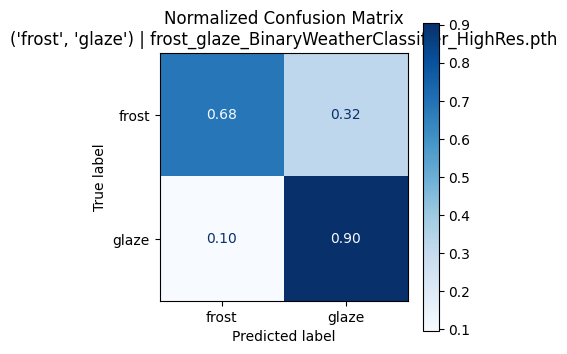

[('frost', 'glaze')] Confusion: 100%|██████████| 4/4 [00:00<00:00,  8.73it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\frost_glaze_frost_glaze_BinaryWeatherClassifier_LowRes.pth.png


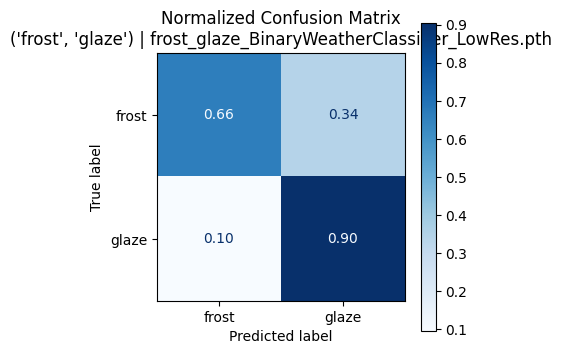

[('glaze', 'hail')] Confusion: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\glaze_hail_glaze_hail_BinaryWeatherClassifier_HighRes.pth.png


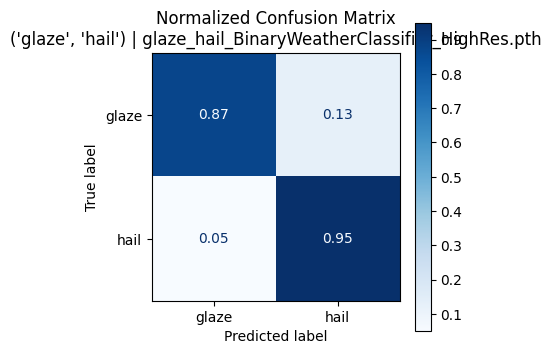

[('glaze', 'hail')] Confusion: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\glaze_hail_glaze_hail_BinaryWeatherClassifier_LowRes.pth.png


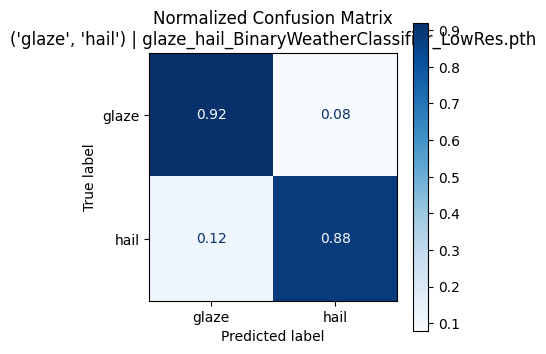

[('rain', 'lightning')] Confusion: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\rain_lightning_rain_lightning_BinaryWeatherClassifier_HighRes.pth.png


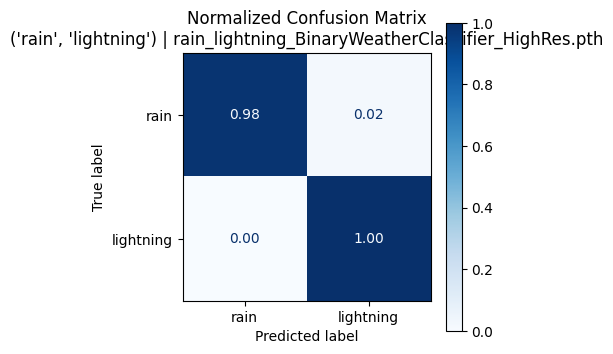

[('rain', 'lightning')] Confusion: 100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\rain_lightning_rain_lightning_BinaryWeatherClassifier_LowRes.pth.png


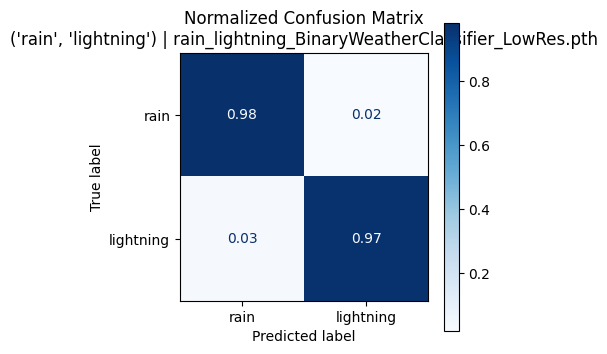

[('snow', 'rime')] Confusion: 100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\snow_rime_snow_rime_BinaryWeatherClassifier_HighRes.pth.png


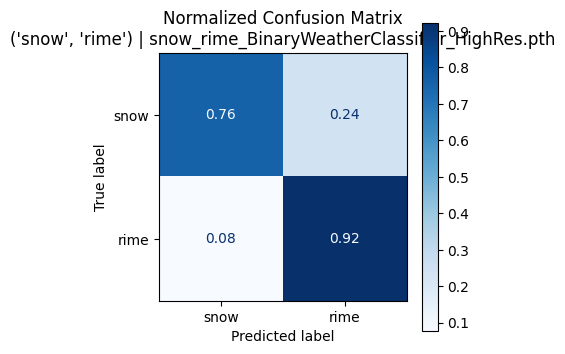

[('snow', 'rime')] Confusion: 100%|██████████| 6/6 [00:00<00:00,  7.83it/s]


📊 Saved normalized confusion matrix to: ../../reports/confusion_matrices_binary\snow_rime_snow_rime_BinaryWeatherClassifier_LowRes.pth.png


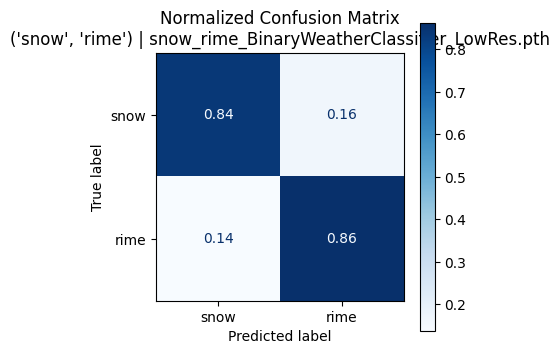

In [22]:
models_dir = "../../models/binary_models"
val_dir = "../../data/val"
device = "cuda" if torch.cuda.is_available() else "cpu"
confusion_out = "../../reports/confusion_matrices_binary"

# Extract class pair and model name from file name
pattern = re.compile(r"([a-zA-Z]+)_([a-zA-Z]+)_(BinaryWeatherClassifier_[a-zA-Z]+)\.pth")

for fname in os.listdir(models_dir):
    match = pattern.match(fname)
    if not match:
        continue

    cls1, cls2, model_type = match.groups()
    class_pair = (cls1, cls2)
    model_path = os.path.join(models_dir, fname)

    # Create model instance
    if "HighRes" in model_type:
        model = BinaryWeatherClassifier_HighRes(class_pair=class_pair)
    else:
        model = BinaryWeatherClassifier_LowRes(class_pair=class_pair)

    evaluate_model_and_confusion(model, model_path, class_pair, val_dir, device=device, save_dir=confusion_out)
